# Goal of this notebook: Stats tests, Models, Analysis
This notebook performs hypothesis testing, builds predictive models, and conducts specific analysis for the Korean bakery sales data referenced in the README. The analysis should be considered semi-final for all intents and purposes. I will replicate this analysis and conduct further analysis in a more-formal way in final_notebook.ipynb. If you have questions about this exploration, please contact me directly on Github.

## Stats tests goals
1. Answer all initial hypotheses

## Model goals
1. Build and fit multiple predictive models for in-sample data
2. Assess predictive accuracy on first out-of-sample (future) data
3. Select best model
4. Assess predictive accuracy on second out-of-sample (future) data

## Analysis goals
1. Determine which items are selling most
2. Determine which items are selling least

# Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import statsmodels.api as sm
import statsmodels.tsa.api as sm

from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# import the tables that were prepped in exploration.ipynb
df = pd.read_csv('bake_sales.csv', index_col=0)
explore = pd.read_csv('explore.csv', index_col=0)
train = pd.read_csv('train.csv', index_col=0)
validate = pd.read_csv('validate.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
# cast the index of each dataframe as datetime format
df.index = df.index.astype('datetime64[ns]')
explore.index = explore.index.astype('datetime64[ns]')
train.index = train.index.astype('datetime64[ns]')
validate.index = validate.index.astype('datetime64[ns]')
test.index = test.index.astype('datetime64[ns]')
# drop a major outlier datapoint
df = df[df.total < 1000000]

# Hypothesis Testing
Initial hypotheses from exploration.ipynb:
1. Revenue is growing over time
2. March has higher revenue than other months
3. Saturday brings more revenue on average than all other days
4. The 신사우동 (Sinsau-Dong) neighborhood buy more on average than other neighborhoods in the city
5. The northwest cardinal region of the city buys more on average than other regions

## Revenue is growing over time
$H_0$: Revenue did not grow over time.

$H_a$: Revenue grew over time.

Confidence interval: 95%

Results do not breach 95% confidence interval, we accept the null hypothesis.
Regression slope: 0.09
p-value: 0.68


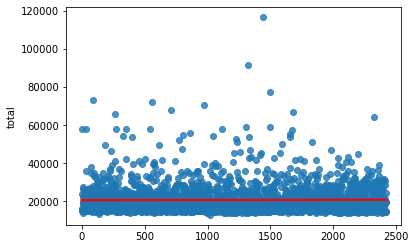

In [3]:
# set alpha
alpha = 0.05

# detemine slope and p-value
slope, intercept, r_value, p_value, std_err = stats.linregress(df.reset_index().index,
                                                               df.total)
# check if test passed 95
if slope > 0 and p_value < alpha:
    print('Revenue is growing over time.')
    print('Regression slope:', slope)
    print('p-value:', p_value)
else:
    print('Results do not breach 95% confidence interval, we accept the null hypothesis.')
    print('Regression slope:', round(slope,2))
    print('p-value:', round(p_value,2))
    
sns.regplot(x=df.reset_index().index, y=df.total, line_kws={'color':'red'})
plt.show()

## March had higher revenue than other months
$H_0$: March did not have statistically-higher revenue than other months.

$H_a$: March had statistically-higher revenue than other months.

Confidence interval: 95%

In [4]:
# create comparison column
df['is_March'] = df.index.month == 3
df[df.is_March].head(3)

,datetime.1,total,place,angbutter,plain bread,jam,americano,croissant,caffe latte,tiramisu croissant,...,pandoro,cheese cake,lemon ade,orange pound,wiener,vanila latte,berry ade,tiramisu,merinque cookies,is_March
datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-01 11:06:00,2020-03-01 11:06:00,34100.0,동면,2.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,True
2020-03-01 11:06:00,2020-03-01 11:06:00,29800.0,동면,1.0,1.0,NaN,NaN,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,True
2020-03-01 11:14:00,2020-03-01 11:14:00,23800.0,동면,1.0,NaN,NaN,2.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [5]:
# set alpha
alpha = 0.05
# run test
t, p = stats.mannwhitneyu(df[df.is_March == True].total, 
                          df[df.is_March == False].total,
                          alternative='greater')
# print results
if p < alpha:
    print('March had statistically higher revenue than other months.\
    We reject the null hypothesis with 95% confidence.')
else:
    print('Results do not breach 95% confidence, we accept the null hypothesis.')

Results do not breach 95% confidence, we accept the null hypothesis.


## Saturday has higher revenue than other weekdays
$H_0$: Saturdays did not have statistically-higher revenue than other weekdays.

$H_a$: Saturdays had statistically-higher revenue than other weekdays.

Confidence interval: 95%

In [6]:
# create comparison column
df['is_Saturday'] = df.index.day_name() == 'Saturday'
df[df.is_Saturday].head(3)

,datetime.1,total,place,angbutter,plain bread,jam,americano,croissant,caffe latte,tiramisu croissant,...,cheese cake,lemon ade,orange pound,wiener,vanila latte,berry ade,tiramisu,merinque cookies,is_March,is_Saturday
datetime,,,,,,,,,,,,,,,,,,,,,
2019-07-13 13:19:00,2019-07-13 13:19:00,14800.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,False,True
2019-07-13 13:22:00,2019-07-13 13:22:00,15600.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2019-07-13 14:54:00,2019-07-13 14:54:00,15800.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,False,True


In [7]:
# set alpha
alpha = 0.05
# run test
t, p = stats.mannwhitneyu(df[df.is_Saturday == True].total, 
                          df[df.is_Saturday == False].total,
                          alternative='greater')
# print results
if p < alpha:
    print('Saturday had statistically higher revenue than other weekdays.\
    We reject the null hypothesis with 95% confidence.')
else:
    print('Results do not breach 95% confidence, we accept the null hypothesis.')

Results do not breach 95% confidence, we accept the null hypothesis.


## Sinsau-Dong generated higher total revenue than other neighborhoods
$H_0$: Sinsau-Dong did not have statistically-higher revenue than other neighborhoods.

$H_a$: Sinsau-Dong had statistically-higher revenue than other neighborhoods.

Confidence interval: 95%

In [8]:
# create comparison column
df['is_Sinsau-Dong'] = df.place == '신사우동'
df[df['is_Sinsau-Dong']].head(3)

,datetime.1,total,place,angbutter,plain bread,jam,americano,croissant,caffe latte,tiramisu croissant,...,lemon ade,orange pound,wiener,vanila latte,berry ade,tiramisu,merinque cookies,is_March,is_Saturday,is_Sinsau-Dong
datetime,,,,,,,,,,,,,,,,,,,,,
2019-08-15 11:15:00,2019-08-15 11:15:00,16100.0,신사우동,2.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
2019-08-16 12:49:00,2019-08-16 12:49:00,18300.0,신사우동,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,False,False,True
2019-08-18 12:40:00,2019-08-18 12:40:00,16300.0,신사우동,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True


In [9]:
# set alpha
alpha = 0.05
# run test
t, p = stats.mannwhitneyu(df[df['is_Sinsau-Dong'] == True].total, 
                          df[df['is_Sinsau-Dong'] == False].total,
                          alternative='greater')
# print results
if p < alpha:
    print('Sinsau-Dong had statistically higher revenue than other neighborhoods.\
        We reject the null hypothesis with 95% confidence.')
else:
    print('Results do not breach 95% confidence, we accept the null hypothesis.')

Sinsau-Dong had statistically higher revenue than other neighborhoods.        We reject the null hypothesis with 95% confidence.


## Northwest Chuncheon generated higher total revenue than other cardinal regions
$H_0$: Northwest Chuncheon did not have statistically-higher revenue than other cardinal regions.

$H_a$: Northwest Chuncheon had statistically-higher revenue than other cardinal regions.

Confidence interval: 95%

In [10]:
# create comparison column
df['is_Northwest'] = ((df.place == '소양동') | 
                      (df.place == '신사우동') | 
                      (df.place == '조운동') | 
                      (df.place == '약사명동') | 
                      (df.place == '근화동'))
df[df.is_Northwest].head(3)

,datetime.1,total,place,angbutter,plain bread,jam,americano,croissant,caffe latte,tiramisu croissant,...,orange pound,wiener,vanila latte,berry ade,tiramisu,merinque cookies,is_March,is_Saturday,is_Sinsau-Dong,is_Northwest
datetime,,,,,,,,,,,,,,,,,,,,,
2019-08-12 15:01:00,2019-08-12 15:01:00,26000.0,소양동,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True
2019-08-15 11:15:00,2019-08-15 11:15:00,16100.0,신사우동,2.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True
2019-08-16 11:54:00,2019-08-16 11:54:00,17800.0,조운동,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,False,False,False,True


In [11]:
# set alpha
alpha = 0.05
# run test
t, p = stats.mannwhitneyu(df[df.is_Northwest == True].total, 
                          df[df.is_Northwest == False].total,
                          alternative='greater')
# print results
if p < alpha:
    print('The northwest region of Chuncheon had statistically higher revenue than other regions.\
        We reject the null hypothesis with 95% confidence.')
else:
    print('Results do not breach 95% confidence, we accept the null hypothesis.')

The northwest region of Chuncheon had statistically higher revenue than other regions.        We reject the null hypothesis with 95% confidence.


# Specific Analysis
1. Determine which items are selling most
2. Determine which items are selling least

## Which three items sell the most?
1. Ang Butter (3223 sold)
2. Croissant (1044 sold)
3. Plain Bread (1023 sold)

## Which three items sell the least?
1. Mad Garlic (0 sold)
2. Croque Monsieur (0 sold)
3. Tiramisu (7 sold)

# Modeling
1. Build and fit multiple predictive models for in-sample data
    * From exploration, sales are consistent over time, so we won't do Holt's Linear Trend
    * From exploration, sales are not cyclical, so we won't do Previous Cycle
2. Assess predictive accuracy on first out-of-sample (future) data
3. Select best model
4. Assess predictive accuracy on second out-of-sample (future) data

## Build, fit models

In [12]:
# Model: Last Observed Value as Prediction
validate['last_observed'] = train.tail(1).total[0]

In [13]:
# Model: Simple Average as Prediction
validate['simple_average'] = train.mean()[0]

In [14]:
# Model: Last Rolling Average as Prediction
validate['30_day_rolling_average'] = train.resample('D').sum()\
                                     .rolling(30).mean()\
                                     .tail(1).total[0]

## Assess predictive accuracy

In [15]:
for col in validate.columns[1:]:
    RMSE = round(sqrt(mean_squared_error(validate['total'], validate[col])), 0)
    print(col + ' RMSE:\n' + str(RMSE) + ' won\n')

last_observed RMSE:
10159.0 won

simple_average RMSE:
8738.0 won

30_day_rolling_average RMSE:
146240.0 won



## Select best model
Simple Average had the lowest RMSE.

## Assess predictive accuracy

In [16]:
test['best_model'] = train.mean()[0]
RMSE = round(sqrt(mean_squared_error(test['total'], test['best_model'])), 0)
print('Best model RMSE:\n' + str(RMSE) + ' won\n')

Best model RMSE:
6295.0 won



# Stats, Models, and Analysis Takeaways
## Stats Tests Findings
1. We cannot say with 95% confidence that revenue is rising over time.
2. We cannot say with 95% confidence that March had higher revenue than other months.
3. We cannot say with 95% confidence that Saturdays generate more revenue than other days.
4. We can say with 95% confidence that Sinsau-Dong generates more revenue than other neighborhoods.
5. We can say with 95% confidence that Northwest Chuncheon generates more revenue than other regions of the city.

## Specific Analytic Findings
1. Items that sold the most: Ang Butter (3223 sold), Croissant (1044 sold), Plain Bread (1023 sold)
2. Items that sold the least: Mad Garlic (0 sold), Croque Monsieur (0 sold), Tiramisu (7 sold)

## Model Performance
The Simple Average as Prediction model performed best with an RMSE of 8738 won and 6295 won on two out-of-sample data splits.